# FINAL PROJECT - DOG BREED DETECTION
###  Name : Sharjil Khan

# IMPORTS

In [10]:
import tensorflow as tf
import tensorflow.compat.v1 as tf
#tf.disable_v2_behavior()

from tensorflow.keras import layers
from tensorflow.python.client import device_lib

import cv2
import re
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
from time import time
import shutil
import sys
from IPython.display import display, Image

from sklearn.metrics import auc
from sklearn.metrics import roc_curve


from keras import layers
from keras import models
from keras import optimizers
from keras.preprocessing.image import ImageDataGenerator


from tensorflow.keras.callbacks import TensorBoard
from tensorflow.python.eager import context

from keras.preprocessing import image
from keras.utils import layer_utils
from keras.utils.data_utils import get_file
from keras.applications.imagenet_utils import preprocess_input
from keras.callbacks import TensorBoard

from keras.layers import Input, Dense, Activation, ZeroPadding2D, BatchNormalization, Flatten, Conv2D, GlobalAveragePooling2D
from keras.layers import AveragePooling2D, MaxPooling2D, Dropout
from keras.models import Model, Sequential 
from keras.optimizers import Adam,RMSprop,SGD
from sklearn.metrics import roc_curve, auc, precision_recall_curve, average_precision_score, roc_auc_score
from sklearn.metrics import confusion_matrix, classification_report, precision_recall_fscore_support, accuracy_score

from keras import backend as K
if K.backend()=='tensorflow':
    K.set_image_data_format('channels_last')

# Config the matlotlib backend as plotting inline in IPython
%matplotlib inline

print("Tensorflow is installed and is version: ",  tf.__version__)
print("Keras is installed and is version: ", tf.keras.__version__)

#with tf.device('/gpu:0'):
#    a = tf.constant([1.0, 2.0, 3.0, 4.0, 5.0, 6.0], shape=[2, 3], name='a')
#    b = tf.constant([1.0, 2.0, 3.0, 4.0, 5.0, 6.0], shape=[3, 2], name='b')
#    c = tf.matmul(a, b)

#with tf.compat.v1.Session() as sess:
#    print (sess.run(c))
    
print(sys.version)
print(device_lib.list_local_devices())

# special matplotlib command for global plot configuration
from matplotlib import rcParams
import matplotlib.cm as cm
import matplotlib as mpl
from matplotlib.colors import ListedColormap
from mpl_toolkits.mplot3d import Axes3D

dark2_colors = [(0.10588235294117647, 0.6196078431372549, 0.4666666666666667),
                (0.9058823529411765, 0.1607843137254902, 0.5411764705882353),
                (0.8509803921568627, 0.37254901960784315, 0.00784313725490196),
                (0.4588235294117647, 0.4392156862745098, 0.7019607843137254),            
                (0.4, 0.6509803921568628, 0.11764705882352941),
                (0.9019607843137255, 0.6705882352941176, 0.00784313725490196),
                (0.6509803921568628, 0.4627450980392157, 0.11372549019607843)]

cmap_set1 = ListedColormap(['#e41a1c', '#377eb8', '#4daf4a'])
dark2_cmap=ListedColormap(dark2_colors)

def set_mpl_params():
    rcParams['figure.figsize'] = (12, 6)
    rcParams['figure.dpi'] = 100
    rcParams['axes.prop_cycle'].by_key()['color'][1]
    rcParams['lines.linewidth'] = 2
    rcParams['axes.facecolor'] = 'white'
    rcParams['font.size'] = 14
    rcParams['patch.edgecolor'] = 'white'
    rcParams['patch.facecolor'] = dark2_colors[0]
    rcParams['font.family'] = 'StixGeneral'

set_mpl_params()

Tensorflow is installed and is version:  1.15.2
Keras is installed and is version:  2.2.4-tf
3.6.10 |Anaconda, Inc.| (default, Mar 25 2020, 23:51:54) 
[GCC 7.3.0]
[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 16637094894874655932
, name: "/device:XLA_CPU:0"
device_type: "XLA_CPU"
memory_limit: 17179869184
locality {
}
incarnation: 7461691890812785822
physical_device_desc: "device: XLA_CPU device"
, name: "/device:XLA_GPU:0"
device_type: "XLA_GPU"
memory_limit: 17179869184
locality {
}
incarnation: 6689552192792903996
physical_device_desc: "device: XLA_GPU device"
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 11329617920
locality {
  bus_id: 1
  links {
  }
}
incarnation: 7299486200549716821
physical_device_desc: "device: 0, name: Tesla K80, pci bus id: 0000:00:1e.0, compute capability: 3.7"
]


# Some General Functions used in various places

In [30]:
# TO CREATE THE LOGS FOR TENSOR BOARD
class TrainValTensorBoard(TensorBoard):
    def __init__(self, log_dir='./logs', **kwargs):
        # Make the original `TensorBoard` log to a subdirectory 'training'
        training_log_dir = os.path.join(log_dir, 'training')
        super(TrainValTensorBoard, self).__init__(training_log_dir, **kwargs)

        # Log the validation metrics to a separate subdirectory
        self.val_log_dir = os.path.join(log_dir, 'validation')

    def set_model(self, model):
        # Setup writer for validation metrics
        self.val_writer = tf.summary.FileWriter(self.val_log_dir)
        super(TrainValTensorBoard, self).set_model(model)

    def on_epoch_end(self, epoch, logs=None):
        # Pop the validation logs and handle them separately with
        # `self.val_writer`. Also rename the keys so that they can
        # be plotted on the same figure with the training metrics
        logs = logs or {}
        val_logs = {k.replace('val_', ''): v for k, v in logs.items() if k.startswith('val_')}
        for name, value in val_logs.items():
            summary = tf.Summary()
            summary_value = summary.value.add()
            summary_value.simple_value = value.item()
            summary_value.tag = name
            self.val_writer.add_summary(summary, epoch)
        self.val_writer.flush()

        # Pass the remaining logs to `TensorBoard.on_epoch_end`
        logs = {k: v for k, v in logs.items() if not k.startswith('val_')}
        super(TrainValTensorBoard, self).on_epoch_end(epoch, logs)

    def on_train_end(self, logs=None):
        super(TrainValTensorBoard, self).on_train_end(logs)
        self.val_writer.close()
        
# PLOT ACCURACY AND LOSS CHARTS FOR THE MODELS AS THEY TRAIN
def plot_accuracies_loss(history):
    acc = history.history['acc']
    val_acc = history.history['val_acc']
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs = range(len(acc))

    plt.plot(epochs, acc, 'g-', label='Training acc', color = 'brown')
    plt.plot(epochs, val_acc, 'g-', label='Validation acc', color = 'orange')
    plt.xlabel("Num of Epochs")
    plt.ylabel("Accuracy")
    plt.title('Training and validation accuracy')
    plt.legend()

    plt.figure()
 
    plt.plot(epochs, loss, 'g-', label='Training loss', color = 'brown')
    plt.plot(epochs, val_loss, 'g-', label='Validation loss', color = 'orange')
    plt.xlabel("Num of Epochs")
    plt.ylabel("Loss")
    plt.title('Training and validation loss')
    plt.legend()
    plt.show()
    
    

# TO SHOW CONFUSION MATRIX
def show_confusion_matrix(cm, target_names):
    plt.figure(figsize=(10, 10))
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.binary)
    plt.title('Confusion matrix')
    plt.set_cmap('Blues')
    plt.colorbar()
    tick_marks = np.arange(len(target_names))
    plt.xticks(tick_marks, target_names, rotation=90)
    plt.yticks(tick_marks, target_names)
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()

# SHOW RESULTS OF CLASSIFICATION
def show_results(model, test_generator):
    # GET ACCURACY SCORE ON THE TEST SET
    test_loss, test_acc = model.evaluate_generator(test_generator, steps=100)
    print('\nTEST accuracy:', test_acc)
    print('TEST loss:', test_loss)
    predictions = []
    labels = []
    indexes = []

    i = 0
        
    for data_batch, labels_batch in test_generator:
        labels.extend(labels_batch)
        predictions.extend(model.predict_classes(data_batch))
        i = i + 1
        if i==len(test_generator):
            break
        
    for i in range (len(test_generator)):
        indexes.extend(next(test_generator.index_generator))
        
    labels = [np.where(r==1)[0][0] for r in labels]
    print("Lables:")
    print(labels)
    print("Predictions:")
    print(predictions)
    print('\nConfusion Matrix')
    cm = confusion_matrix(labels, predictions)
    print(cm)
    print('\nClassification Report')
    target_names = [*test_generator.class_indices.keys()]
    print(classification_report(labels, predictions, target_names=target_names))
    show_confusion_matrix(cm, target_names)
    

# FUNCTION TO CHANGE THE DIRECTORY NAMES 
def change_directory_names (source, destination, change = False):
    files = os.listdir(source)
    for f in files:
        # check if the file name has numbers
        has_number = re.search(r'\d+', f)
        if has_number != None:
            src = os.path.join(source,f)
            print("\nSrc:%s"%src)
            
            f_prime = "-".join(f.split("-")[1:])
            if f_prime != "":
                dst = os.path.join(destination,f_prime)
            else:
                dst = os.path.join(destination,f)
            print("dst : %s\n"%dst)
            if change == True:
                print("Changing directory Name")
                shutil.copytree(src,dst)
        else :
            print("no numbers --> %s"%f)
    return


# Function to zoom into an image to improve accuracy scores
def resize_image(filename):
    img_org = cv2.imread(filename)
    #read in as black and white for processing
    img = cv2.imread(filename, 0)
    
    #gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
    gray = cv2.medianBlur(img,5)

    corners = cv2.goodFeaturesToTrack(gray,25,0.01,10)
    corners = np.int0(corners)

    xmin = 0
    ymin = 0
    xmax = 0
    ymax = 0
    for i in corners:
        x,y = i.ravel()
        if (xmin == 0): xmin = x
        if (x < xmin): xmin = x
        
        if (ymin == 0): ymin = y
        if (y < ymin): ymin = y
    
        if (xmax == 0): xmax = x
        if (x > xmax): xmax = x
        
        if (ymax == 0): ymax = y
        if (y > ymax): ymax = y
    
    crop_img = img_org[ymin:ymax, xmin:xmax]
    return crop_img




In [12]:
# CHANGING NAMES OF THE DIRECTORIES AND GETTING THE VALUES FOR THE DICT ENTRY
change_directory_names("../data/raw","../data/interim", change = True)



Src:../data/raw/n02111277-Newfoundland
dst : ../data/interim/Newfoundland

Changing directory Name


FileExistsError: [Errno 17] File exists: '../data/interim/Newfoundland'

# Create Dog Directories and split train, validation & test

In [13]:



# CREATES THE DIRECTORY STRUCTURES WITH THE PROPER TRAINING, VALIDATION AND TEST SPLIT
def create_dog_images_dirs (source, destination, dir_split_list):
    
    # Check if a list of dogs where provided if not return
    if (len(dir_split_list)) == 0:
        return 
    
    # Create the basic directory paths for the three main dirs
    testval_dirs = destination
    train_d = os.path.join(testval_dirs,'train')
    val_d = os.path.join(testval_dirs,'validation')
    test_d = os.path.join(testval_dirs,'test')
                        
    # Remove the old directories.    
    if os.path.exists(testval_dirs):
             shutil.rmtree(testval_dirs)
            
    # Create new directories.            
    os.makedirs(testval_dirs)
    os.makedirs(train_d)
    os.makedirs(val_d)
    os.makedirs(test_d) 
    
    # Iterate through each dog  
    for dog in dir_split_list:

        # Get the dogs name
        name = dog['name']
    
        # Create dirs with the name of the dog
        dog_train_dst = os.path.join(train_d, name)
        dog_val_dst = os.path.join(val_d, name)
        dog_test_dst = os.path.join(test_d, name)
    
        os.makedirs(dog_train_dst)
        os.makedirs(dog_val_dst)
        os.makedirs(dog_test_dst)
    
        # Collect info about this dogs directory and calculate the split numbers
        path, dirs, files = os.walk(os.path.join(source, name)).__next__()
        file_count = len(files)    
        train_count = int(file_count * dog['train'])
        val_count = int(file_count * dog['val'])
        test_count = file_count - train_count - val_count

        # Copy the files
        for i, file in enumerate(files, start =1):
            if i <= train_count: 
                shutil.copy(os.path.join(path, file),os.path.join(dog_train_dst, file))
            if i <= val_count: 
                shutil.copy(os.path.join(path, file),os.path.join(dog_val_dst, file))
            if i <= test_count: 
                shutil.copy(os.path.join(path, file),os.path.join(dog_test_dst, file))  
    return train_d, val_d, test_d
 


# Returns a dict of dogs. the number of dogs depends on count
def return_dict(path, trn, vl, tst, count):
    lst_dict = []
    files = os.listdir(path)
    for i, f in enumerate(files) :
        if os.path.isdir(os.path.join(path,f)):       # Making sure this is a dir. ignore files such as .gitkeep etc.
            lst_dict.append({'name': f, 'train': trn, 'val': vl, 'test': tst})
            if i == (count-1):
                break
        else: 
            count +=1      # the iteration was wasted on a non-directory so increase iteration
    return lst_dict


def dog_dict_list(path, trn, vl, tst, number_of_dogs):

    dogs_count = return_dict(path, trn, vl, tst, number_of_dogs)

    # ELSE NUM OF DOGS IS USED TO CHOOSE BETWEEN 2, 4, 8 
    dogs2 = [{'name': 'golden_retriever', 'train': trn, 'val': vl, 'test': tst},
             {'name': 'curly-coated_retriever', 'train': trn, 'val': vl, 'test': tst}
            ]

    dogs4 = [{'name': 'golden_retriever', 'train': trn, 'val': vl, 'test': tst},
             {'name': 'curly-coated_retriever', 'train': trn, 'val': vl, 'test': tst},
             {'name': 'Japanese_spaniel', 'train': trn, 'val': vl, 'test': tst},
             {'name': 'Chihuahua', 'train': trn, 'val': vl, 'test': tst}
            ]

    dogs8 = [{'name': 'golden_retriever', 'train': trn, 'val': vl, 'test': tst},
             {'name': 'curly-coated_retriever', 'train': trn, 'val': vl, 'test': tst},
             {'name': 'Australian_terrier', 'train': trn, 'val': vl, 'test': tst},
             {'name': 'Chihuahua', 'train': trn, 'val': vl, 'test': tst},
             {'name': 'German_shepherd', 'train': trn, 'val': vl, 'test': tst},
             {'name': 'Japanese_spaniel', 'train': trn, 'val': vl, 'test': tst},
             {'name': 'Tibetan_mastiff', 'train': trn, 'val': vl, 'test': tst},
             {'name': 'toy_poodle', 'train': trn, 'val': vl, 'test': tst}
            ]


    if number_of_dogs == (2 | 4 | 8 ):
        if number_of_dogs == 2: 
             dogs  = dogs2
        elif number_of_dogs == 4: 
             dogs  = dogs4
        elif number_of_dogs== 8: 
             dogs  = dogs8
    else:
        dogs  = dogs_count
    return dogs


def create_data_generatores(train_dir, validation_dir, test_dir):
    image_X = 128
    image_Y = 128
    # All images will be rescaled by 1./255
    datagen = ImageDataGenerator(rescale=1./255)

    # generator for the training data
    train_generator = datagen.flow_from_directory(
        # This is the target directory
        train_dir,
        # All images will be resized to 64x64
        target_size=(image_X , image_Y),
        batch_size=8,
        # Since we use binary_crossentropy loss, we need binary labels
        class_mode='categorical')

    # generator for the validation data
    validation_generator = datagen.flow_from_directory(
        validation_dir,
        target_size=(image_X , image_Y),
        batch_size=8,
        class_mode='categorical')

    # generator for the test data
    test_generator = datagen.flow_from_directory(
        test_dir,
        target_size=(image_X , image_Y),
        # NO shuffle for the test set to be able to track the file names
        shuffle = False,
        batch_size=8,  # this just makes sure it gets through memory
        class_mode='categorical')
    return train_generator, validation_generator, test_generator


    
 

# AN INITIAL LOOK AT WHAT THE DOG IMAGES LOOK LIKE

In [14]:
print(dog_dict_list('../data/interim', 0.70, 0.15, 0.15, 2))

[{'name': 'Lhasa', 'train': 0.7, 'val': 0.15, 'test': 0.15}, {'name': 'Bouvier_des_Flandres', 'train': 0.7, 'val': 0.15, 'test': 0.15}]


Found 235 images belonging to 2 classes.
Found 49 images belonging to 2 classes.
Found 52 images belonging to 2 classes.
[[1. 0.]
 [1. 0.]
 [0. 1.]
 [0. 1.]
 [1. 0.]
 [0. 1.]
 [0. 1.]
 [0. 1.]]


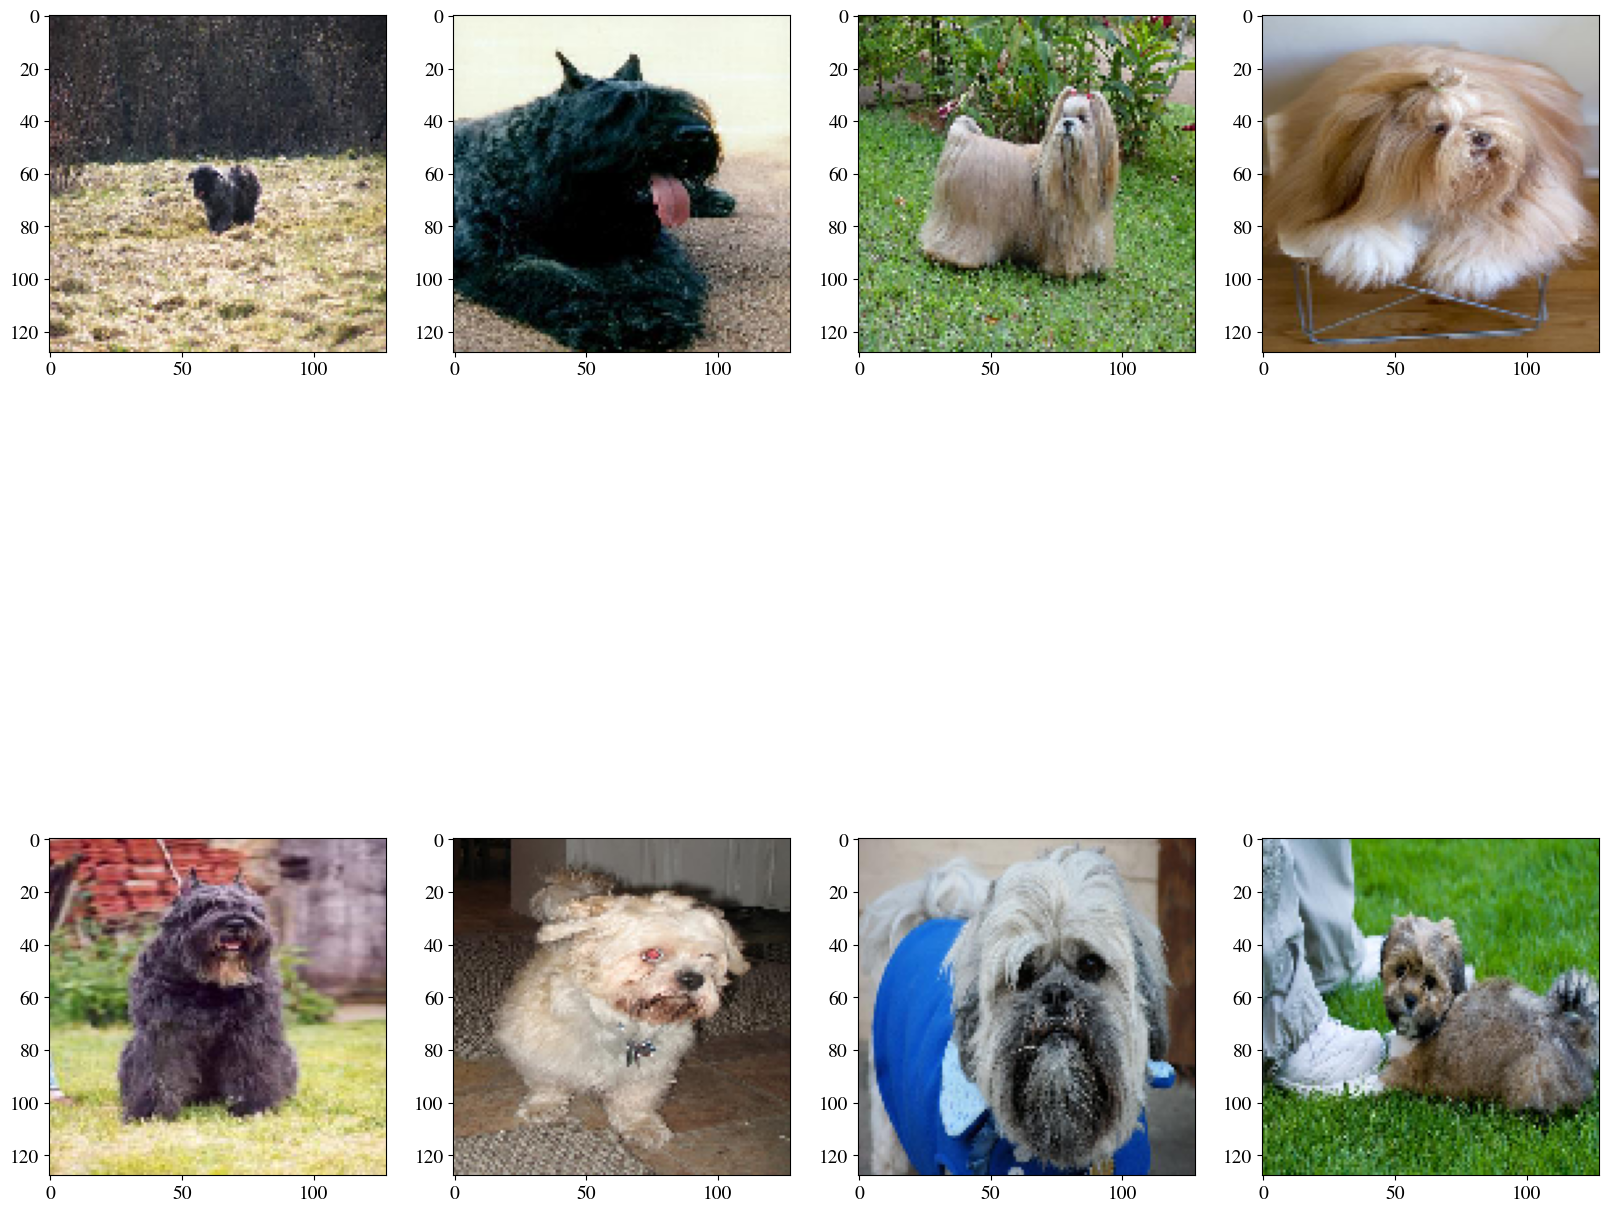

In [15]:
# CREATE THE DIRECTORIES
train_dir, validation_dir, test_dir = create_dog_images_dirs ('../data/interim','../data/processed',dog_dict_list('../data/interim', 0.70, 0.15, 0.15, 2))

# THEN CREATE THE DATA GENERATORS
train_generator, validation_generator, test_generator = create_data_generatores(train_dir, validation_dir, test_dir)

data_batch, labels_batch = train_generator[0]
print(labels_batch)
plt.rcParams['figure.figsize'] = (20.0, 20.0)
f, ax = plt.subplots(nrows=2, ncols=4)

j=0
i=0
for image in data_batch:
        ax[j, i].imshow(image)
        i = i + 1
        if i == 4 :
            j = j+1
            i = 0


# FINAL CNN MODEL USED 

In [16]:
K.clear_session()

def CNN_model_create(train_generator, num_of_dogs):
    for data_batch, labels_batch in train_generator:
        print('data batch shape:', data_batch.shape)
        print('labels batch shape:', labels_batch.shape)
        break
    #data_batch, labels_batch = train_generator[0]
    batch_size = len(labels_batch)
    print("Batch Size: %d"%batch_size)

    model = Sequential(name='FiveLayerModel')
    model.add(Conv2D(batch_size, (3, 3), padding='same', activation='relu',
                            input_shape=data_batch.shape[1:], name = 'conv1'))
    model.add(MaxPooling2D((2, 2), name='max_pool1'))
    model.add(Dropout(rate=0.2))
    model.add(Conv2D(64, (3, 3), padding='same', activation='relu', name = 'conv2'))
    model.add(MaxPooling2D((2, 2), name='max_pool2'))
    model.add(Dropout(rate=0.2))
    model.add(Conv2D(128, (3, 3), padding='same', activation='relu', name = 'conv3'))
    model.add(MaxPooling2D((2, 2), name='max_pool3'))
    model.add(Dropout(rate=0.2))
    model.add(Conv2D(128, (3, 3), padding='same', activation='relu', name = 'conv4'))
    model.add(MaxPooling2D((2, 2), name='max_pool4'))
    model.add(Conv2D(256, (3, 3), padding='same', activation='relu', name = 'conv5'))
    model.add(Conv2D(512,(3, 3), padding='same', activation='relu', name = 'conv6'))
    model.add(MaxPooling2D((2, 2), name='max_pool5'))
    model.add(Flatten())
    model.add(Dense(512, kernel_initializer='glorot_uniform', activation='relu', name='fc1'))
    model.add(Dense(NUM_OF_DOGS, kernel_initializer='glorot_uniform', activation='softmax', name='fc2'))

    model.compile(loss='categorical_crossentropy',
                  optimizer = 'rmsprop',
                  #optimizer=optimizers.RMSprop(lr=1e-4),
                  metrics=['acc'])
    #model.compile(optimizer="adam", loss="binary_crossentropy", metrics = ["accuracy"])
    return model



# Fit model
def fit_model(model, train_generator, validation_generator, epoc):
    history_model = model.fit_generator(
        train_generator,
        steps_per_epoch=100,
        epochs=epoc,
        validation_data=validation_generator,
        validation_steps=50,
        verbose=1, 
        callbacks=[TrainValTensorBoard("logs/{}".format(time()), write_graph=True)])
    return history_model
    


# Function to train the model and display result on test set

In [33]:
SOURCE = '../data/interim'
DESTINATION = '../data/processed'
TRN = 0.70  # Training data percentage
VL = 0.15   # Validation data percentage
TST = 0.15  # Test data percentage.

def run_CNN_pipeline(num_of_dogs, epoc):
    # CREATE THE DIRECTORIES
    train_dir, validation_dir, test_dir = create_dog_images_dirs (SOURCE, DESTINATION , dog_dict_list(SOURCE, TRN, VL, TST, num_of_dogs))

    # THEN CREATE THE DATA GENERATORS
    train_generator, validation_generator, test_generator = create_data_generatores(train_dir, validation_dir, test_dir)

    # CREATE THE MODEL
    MODEL = CNN_model_create(train_generator, NUM_OF_DOGS)

    # GET A SUMMARY FOR THE MODEL
    MODEL .summary()

    # FIT MODEL
    history = fit_model(MODEL, train_generator, validation_generator, epoc)

    # PLOT ACCURACIES DURING TRAINING
    plot_accuracies_loss(history)

    # SHOW RESULTS ON TEST SET
    show_results(MODEL, test_generator)
    
    # Return model and class labels list
    names = [*train_generator.class_indices.keys()]
    return MODEL, names

# CNN MODEL: Classification between 8 dog breeds.

Found 966 images belonging to 8 classes.
Found 204 images belonging to 8 classes.
Found 215 images belonging to 8 classes.
data batch shape: (8, 128, 128, 3)
labels batch shape: (8, 8)
Batch Size: 8
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1 (Conv2D)               (None, 128, 128, 8)       224       
_________________________________________________________________
max_pool1 (MaxPooling2D)     (None, 64, 64, 8)         0         
_________________________________________________________________
dropout_13 (Dropout)         (None, 64, 64, 8)         0         
_________________________________________________________________
conv2 (Conv2D)               (None, 64, 64, 64)        4672      
_________________________________________________________________
max_pool2 (MaxPooling2D)     (None, 32, 32, 64)        0         
_________________________________________________________________
dropout_1

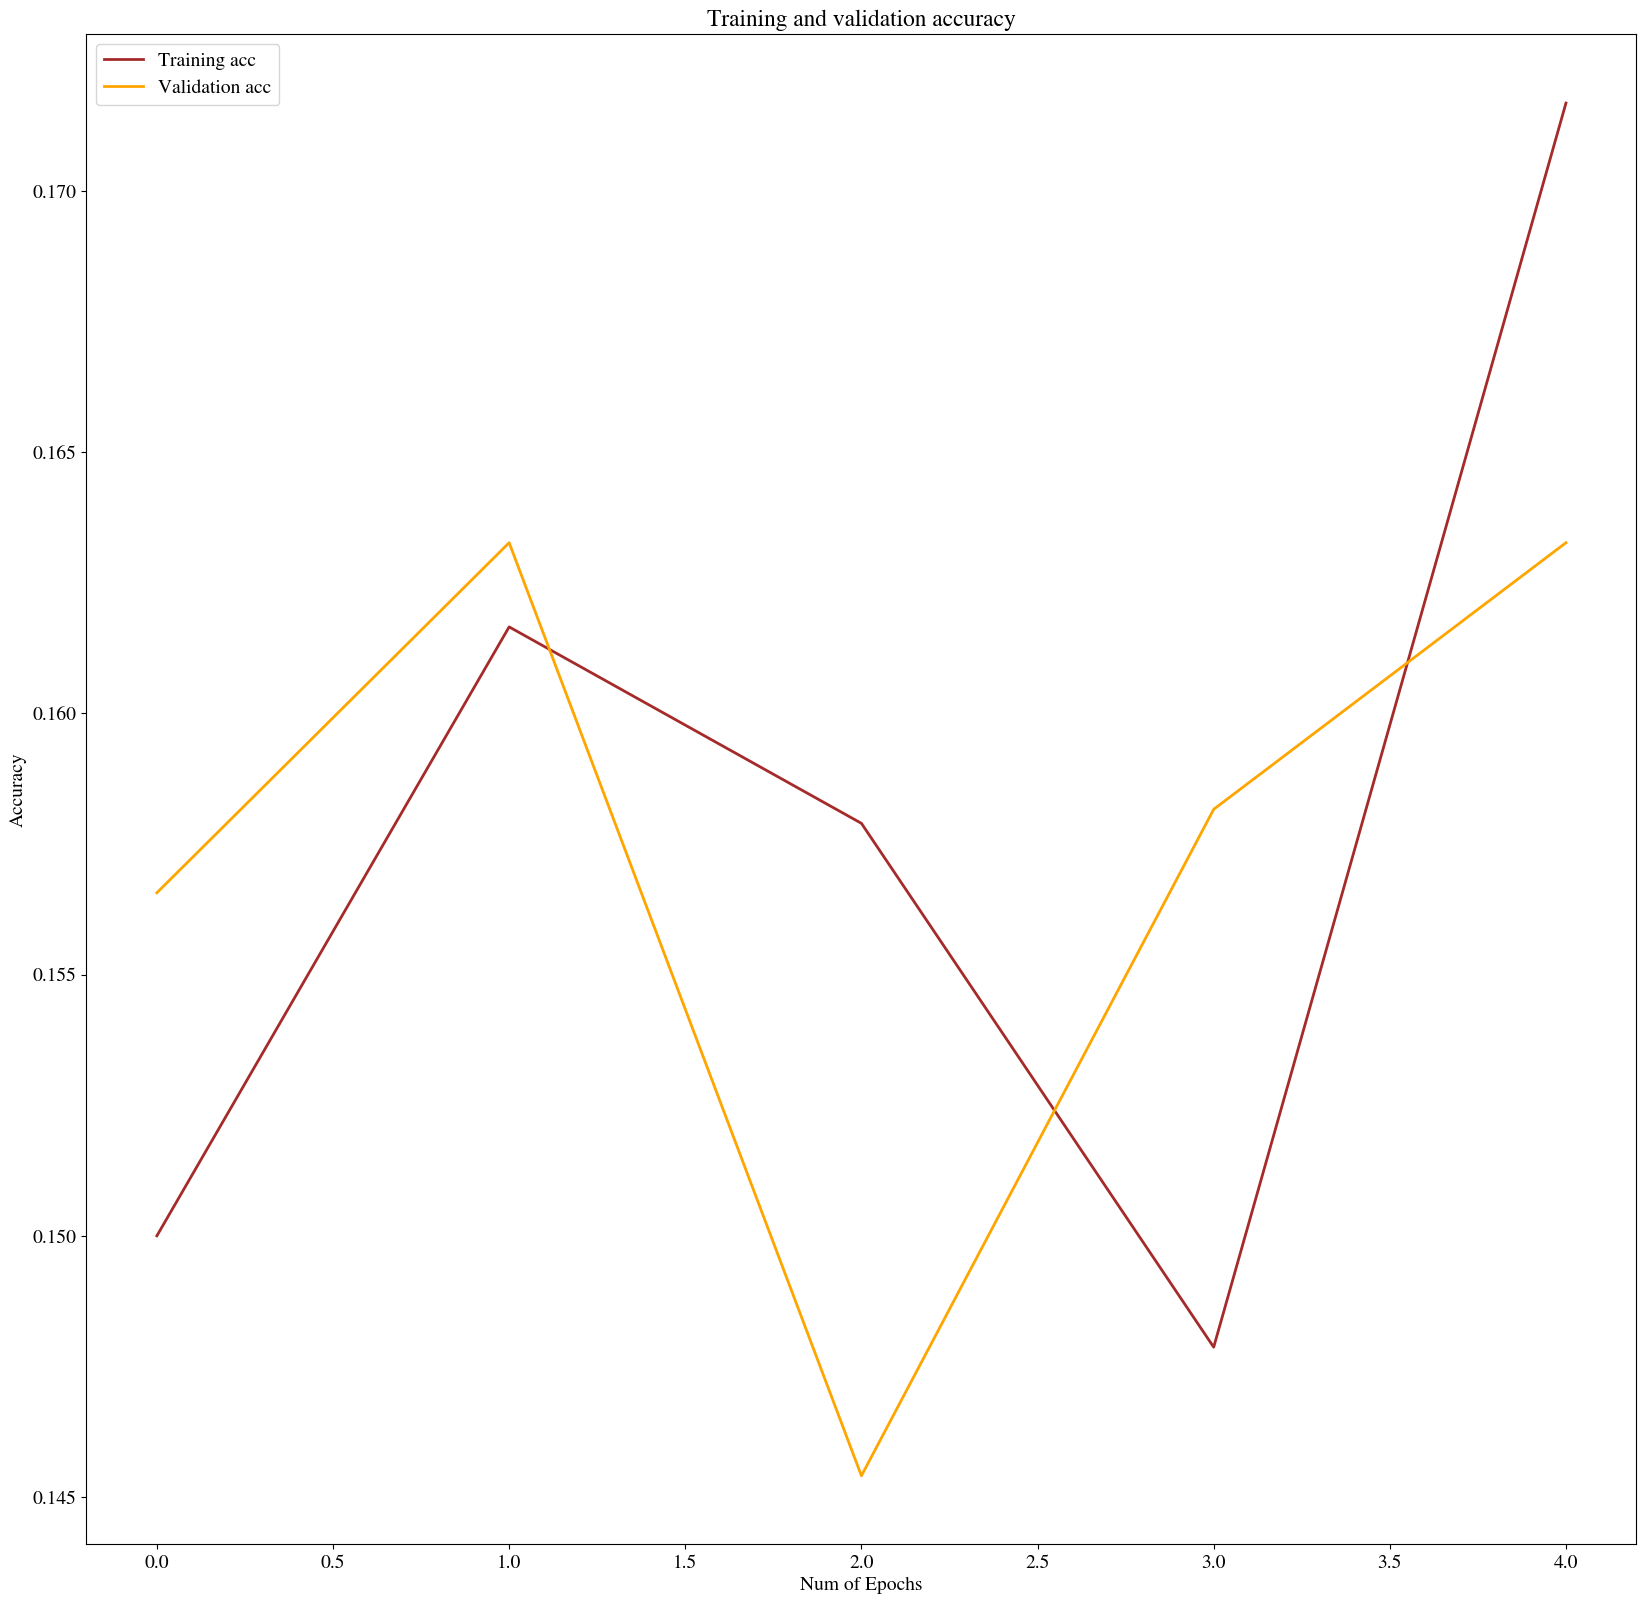

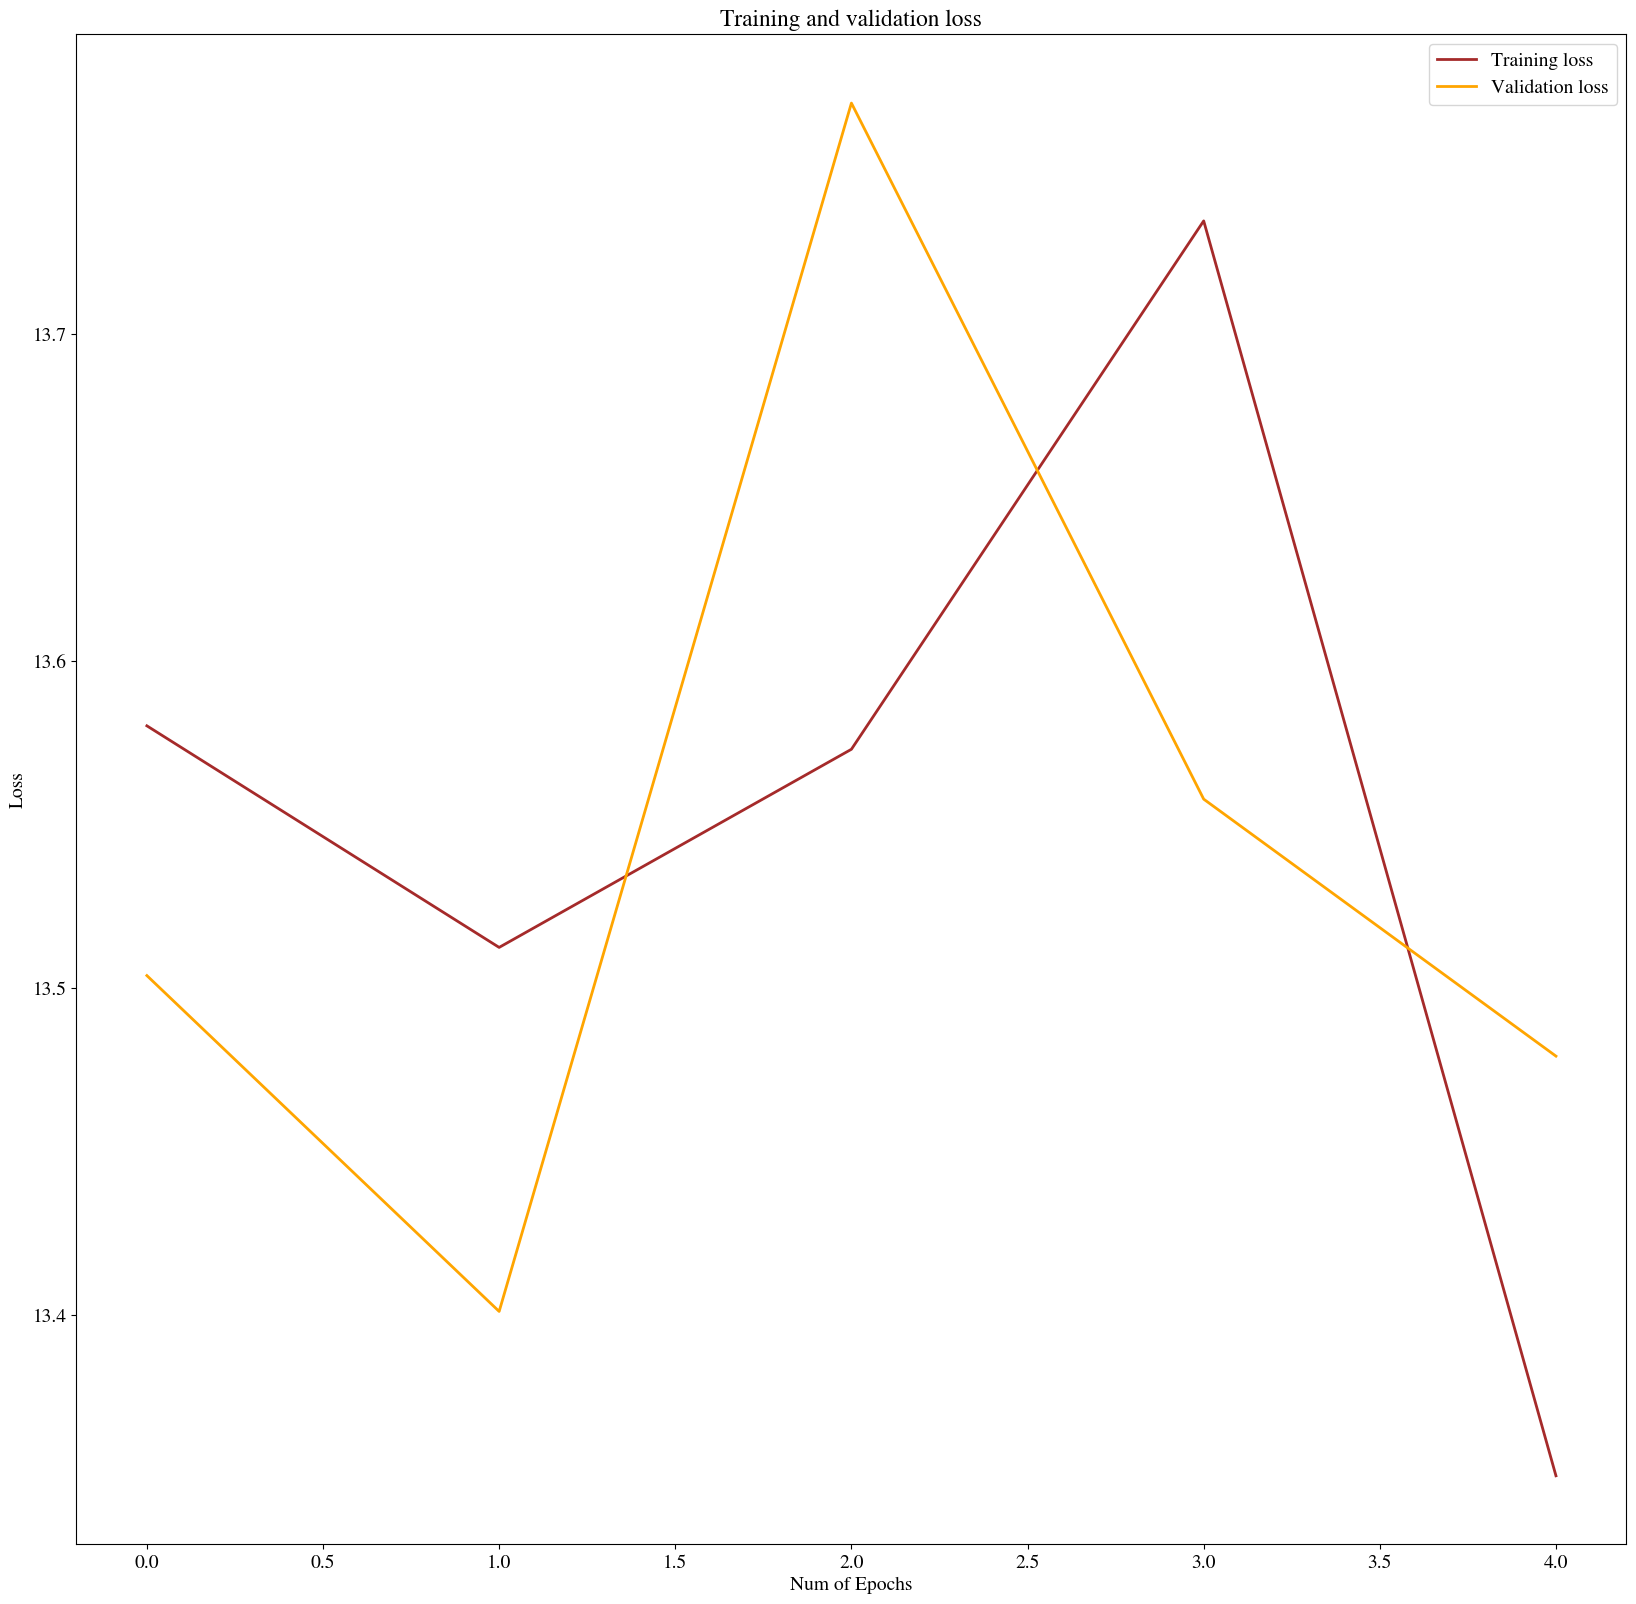


TEST accuracy: 0.17063989962358847
TEST loss: 13.360544053942824
Lables:
[5, 5, 5, 5, 5, 5, 5, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5]
Predictions:
[3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,

/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


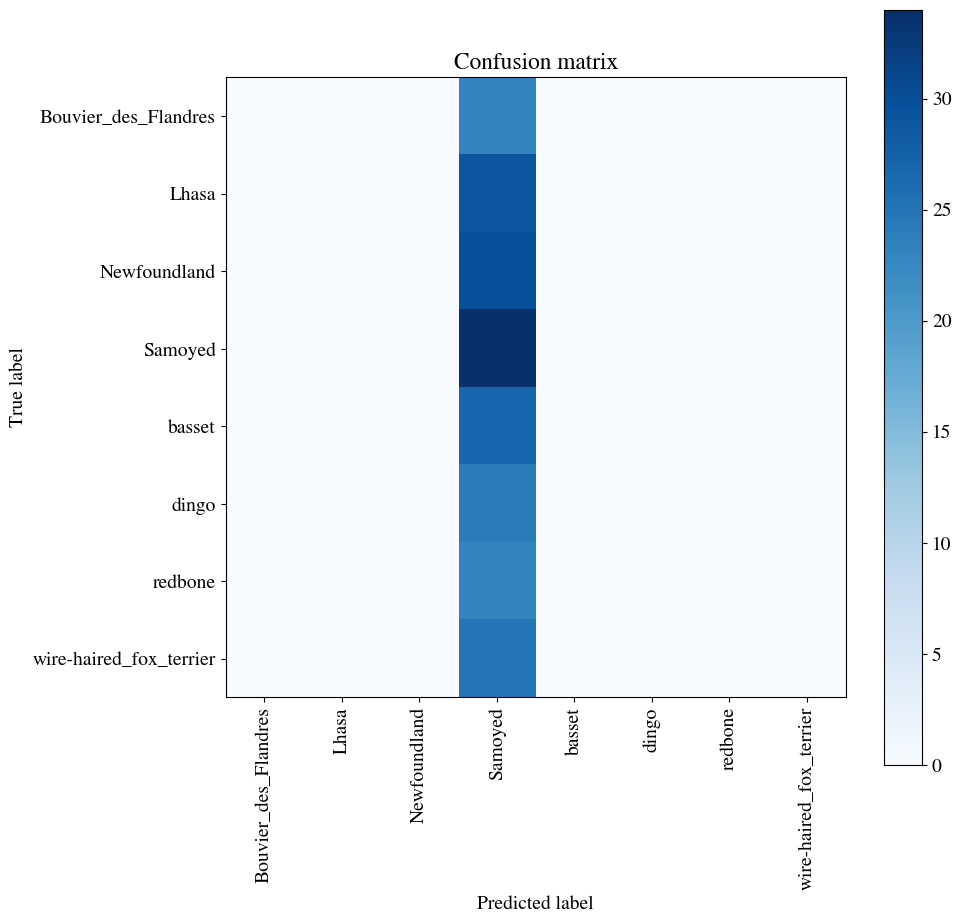

In [36]:
NUM_OF_DOGS = 8
EPOC = 5
model, names= run_CNN_pipeline(NUM_OF_DOGS, EPOC)

In [37]:
print(names)

['Bouvier_des_Flandres', 'Lhasa', 'Newfoundland', 'Samoyed', 'basset', 'dingo', 'redbone', 'wire-haired_fox_terrier']


# CNN MODEL : Classification between 16 dog breeds.

In [ ]:
NUM_OF_DOGS = 16
EPOC = 70
run_CNN_pipeline(NUM_OF_DOGS, EPOC)

# CNN MODEL: Classification between 32 dog breeds.

In [ ]:
NUM_OF_DOGS = 32
EPOC = 100
run_CNN_pipeline(NUM_OF_DOGS, EPOC)

# TRANSFER LEARNING USING ResNet50, Xception & InceptionResNetV2

In [23]:
K.clear_session()

from keras.applications import InceptionResNetV2
from keras.applications.resnet50 import ResNet50
from keras.applications.xception import Xception


def Transfer_model_create(train_generator, num_of_dogs):
    for data_batch, labels_batch in train_generator:
        print('data batch shape:', data_batch.shape)
        print('labels batch shape:', labels_batch.shape)
        break
    #data_batch, labels_batch = train_generator[0]
    batch_size = len(labels_batch)
    print("Batch Size: %d"%batch_size)
    print(data_batch.shape[1:])
    
   # conv_base = ResNet50(weights = 'imagenet', include_top= False, input_shape = data_batch.shape[1:])
    #conv_base = InceptionResNetV2(weights = 'imagenet', include_top= False, input_shape = data_batch.shape[1:])
    conv_base = Xception(weights= 'imagenet', include_top= False, input_shape = data_batch.shape[1:])
    #conv_base.trainable = False
    
    print("Number of Trainable weights:", len(conv_base.trainable_weights))

    for layer in conv_base.layers[:80]:
        layer.trainable = False #False
    for layer in conv_base.layers[80:]:
        layer.trainable = True
    print("Number of Trainable weights:", len(conv_base.trainable_weights))

    model = Sequential(name='TransferModel')
    model.add(conv_base)

    model.add(Conv2D(256,(1,1), padding='same',activation='relu'))

    #model.add(Conv2D(256,(3,3), padding='same',activation='relu'))
    model.add(MaxPooling2D(pool_size=(2,2)))
    model.add(BatchNormalization())

    model.add(Flatten())
    
    
    model.add(Dense(NUM_OF_DOGS, kernel_initializer='glorot_uniform', activation='softmax', name='fc2'))

    model.compile(loss='categorical_crossentropy',
                  #optimizer = 'rmsprop',
                  optimizer = 'adam',
                  #optimizer=optimizers.RMSprop(lr=2e-5),
                  metrics=['acc'])
    #model.compile(optimizer="adam", loss="binary_crossentropy", metrics = ["accuracy"])
    return model

# CREATE THE DIRECTORIES
#train_dir, validation_dir, test_dir = create_dog_images_dirs (PATH, dog_dict_list(PATH, TRN, VL, TST, num_of_dogs))
# CREATE THE DIRECTORIES
#train_dir, validation_dir, test_dir = create_dog_images_dirs (SOURCE, DESTINATION , dog_dict_list(SOURCE, TRN, VL, TST, num_of_dogs))

# THEN CREATE THE DATA GENERATORS
#train_generator, validation_generator, test_generator = create_data_generatores(train_dir, validation_dir, test_dir)

#TRANSFER_model = Transfer_model_create(train_generator, 32)
#TRANSFER_model.summary()




In [26]:
PATH = './dog_images_all'
TRN = 0.70  # Training data percentage
VL = 0.15   # Validation data percentage
TST = 0.15  # Test data percentage.
SOURCE = '../data/interim'
DESTINATION = '../data/processed'
TRN = 0.70  # Training data percentage
VL = 0.15   # Validation data percentage
TST = 0.15  # Test data percentage.


def run_Transfer_pipeline(num_of_dogs, epoc):
    # CREATE THE DIRECTORIES
    #train_dir, validation_dir, test_dir = create_dog_images_dirs (PATH, dog_dict_list(PATH, TRN, VL, TST, num_of_dogs))
    train_dir, validation_dir, test_dir = create_dog_images_dirs (SOURCE, DESTINATION , dog_dict_list(SOURCE, TRN, VL, TST, num_of_dogs))

    # THEN CREATE THE DATA GENERATORS
    train_generator, validation_generator, test_generator = create_data_generatores(train_dir, validation_dir, test_dir)

    # CREATE THE MODEL
    MODEL = Transfer_model_create(train_generator, NUM_OF_DOGS)

    # GET A SUMMARY FOR THE MODEL
    MODEL .summary()

    # FIT MODEL
    history = fit_model(MODEL, train_generator, validation_generator, epoc)

    # PLOT ACCURACIES DURING TRAINING
    plot_accuracies_loss(history)

    # SHOW RESULTS ON TEST SET
    show_results(MODEL, test_generator)
    return

# TRANSFER LEARNING MODEL: Classification with 32 Dog Breeds

Found 3956 images belonging to 32 classes.
Found 836 images belonging to 32 classes.
Found 881 images belonging to 32 classes.
data batch shape: (8, 75, 75, 3)
labels batch shape: (8, 32)
Batch Size: 8
(75, 75, 3)
Number of Trainable weights: 154
Number of Trainable weights: 154
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
xception (Model)             (None, 3, 3, 2048)        20861480  
_________________________________________________________________
flatten_2 (Flatten)          (None, 18432)             0         
_________________________________________________________________
fc2 (Dense)                  (None, 32)                589856    
Total params: 21,451,336
Trainable params: 21,396,808
Non-trainable params: 54,528
_________________________________________________________________
Epoch 1/200
100/100 [==============================] - 19s 187ms/step - loss: 3.6739 - acc: 0.0412 - val_loss

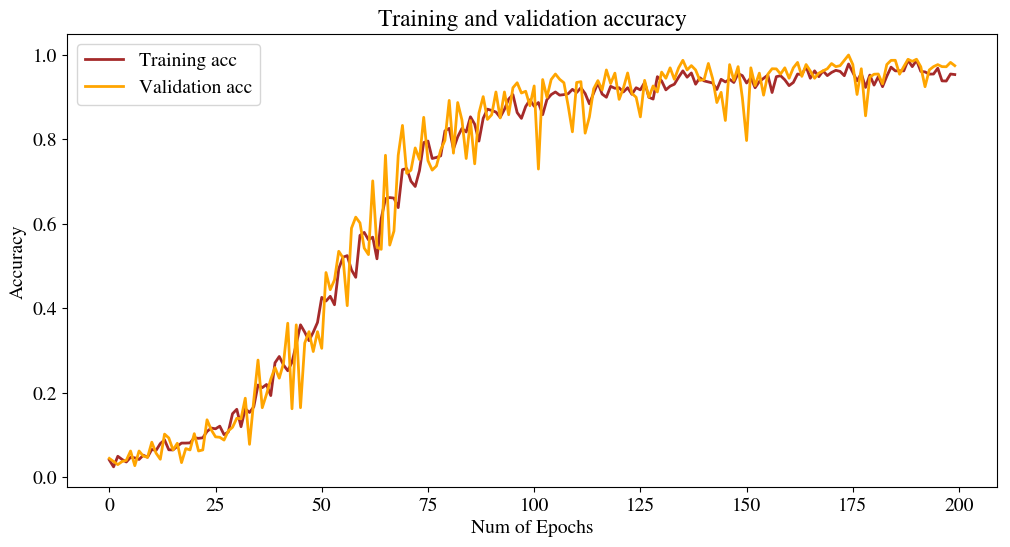

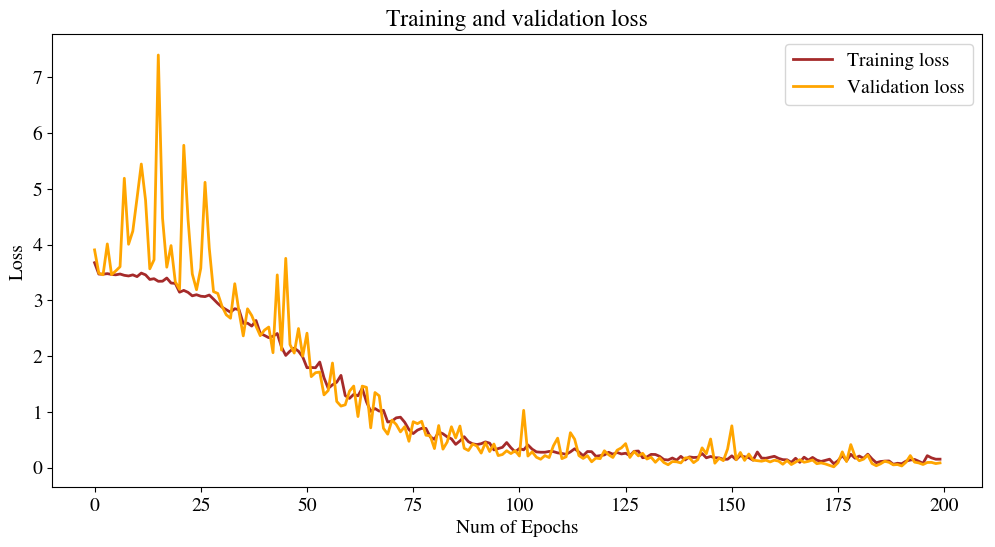


TEST accuracy: 0.97125
TEST loss: 0.08361115617914948

Confusion Matrix
[[31  0  0 ...  0  0  0]
 [ 0 23  0 ...  0  0  0]
 [ 0  0 30 ...  0  0  0]
 ...
 [ 0  0  0 ... 24  0  0]
 [ 0  0  0 ...  0 27  0]
 [ 0  0  0 ...  0  0 29]]

Classification Report
                                precision    recall  f1-score   support

                      Airedale       1.00      1.00      1.00        31
American_Staffordshire_terrier       1.00      0.88      0.94        26
            Australian_terrier       1.00      1.00      1.00        30
                 Border_collie       0.88      0.96      0.92        23
                Border_terrier       0.96      0.96      0.96        27
                      Cardigan       0.92      0.96      0.94        24
                      Doberman       1.00      0.96      0.98        23
                   EntleBucher       1.00      1.00      1.00        31
                Great_Pyrenees       0.97      1.00      0.99        33
                  Ibizan_ho

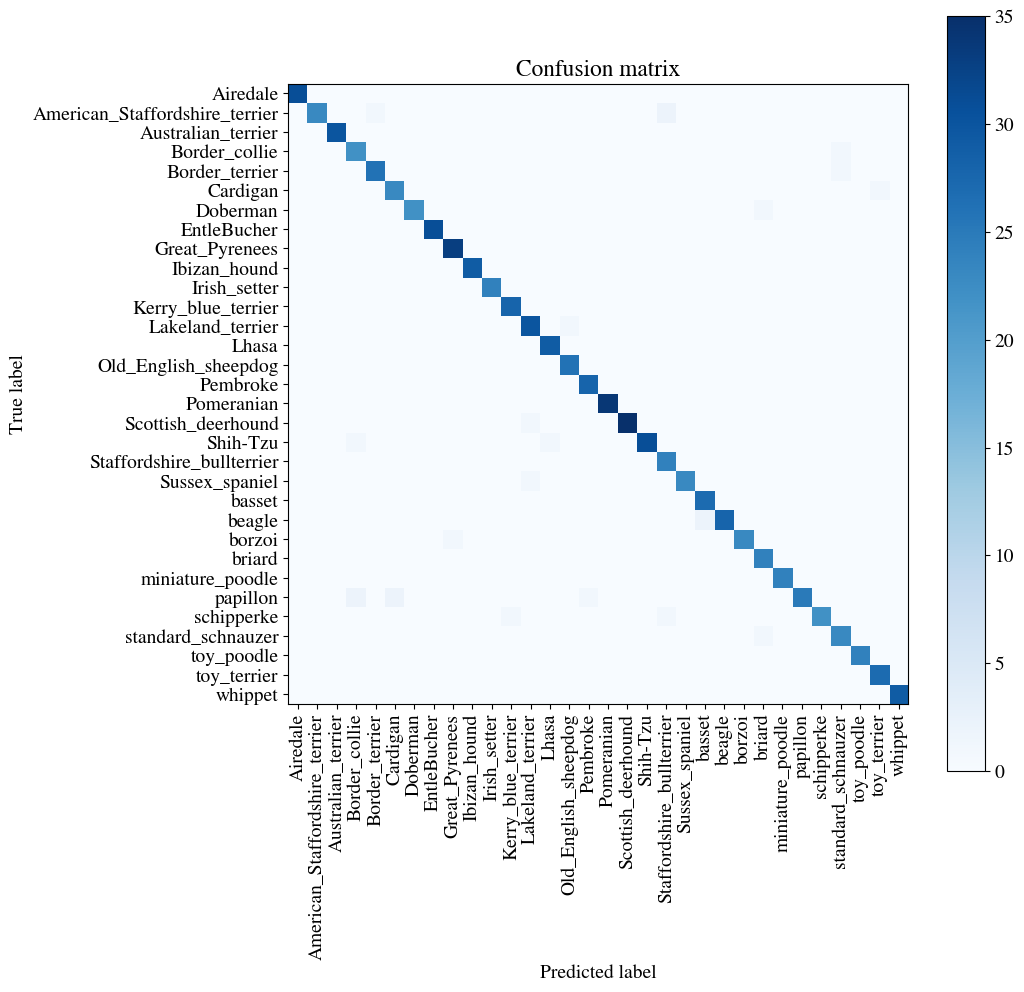

In [110]:
NUM_OF_DOGS = 32
EPOC = 200
run_Transfer_pipeline(NUM_OF_DOGS, EPOC)

Found 13767 images belonging to 115 classes.
Found 2901 images belonging to 115 classes.
Found 3068 images belonging to 115 classes.
data batch shape: (8, 128, 128, 3)
labels batch shape: (8, 115)
Batch Size: 8
(128, 128, 3)

83689472/83683744 [==============================] - 4s 0us/step
Number of Trainable weights: 154
Number of Trainable weights: 63
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
xception (Model)             (None, 4, 4, 2048)        20861480  
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 4, 4, 256)         524544    
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 2, 2, 256)         0         
_________________________________________________________________
batch_normalization_5 (Batch (None, 2, 2, 256)         1024      
__________________________________________________

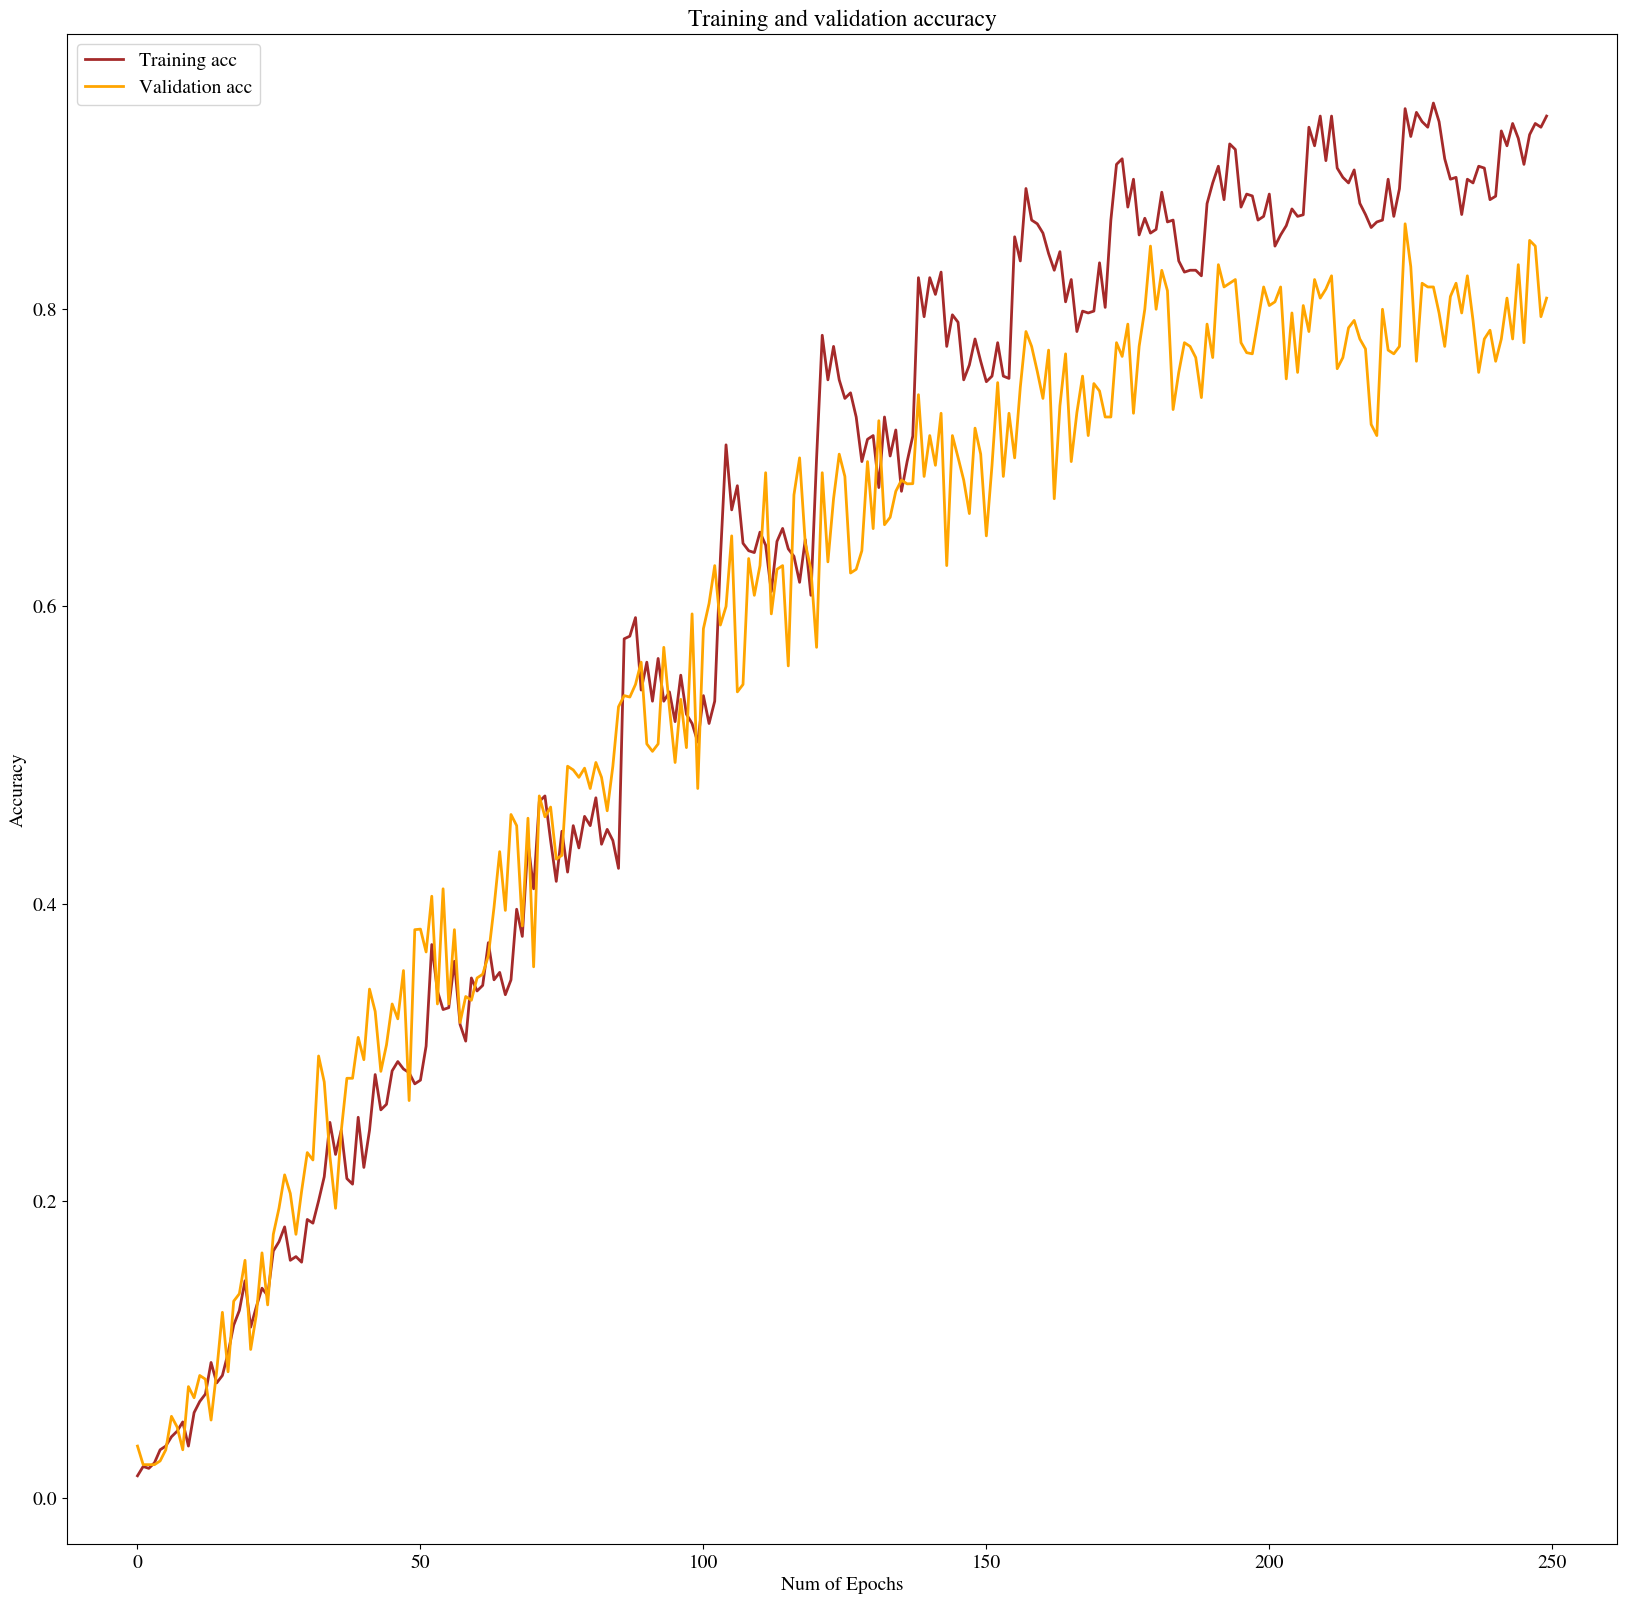

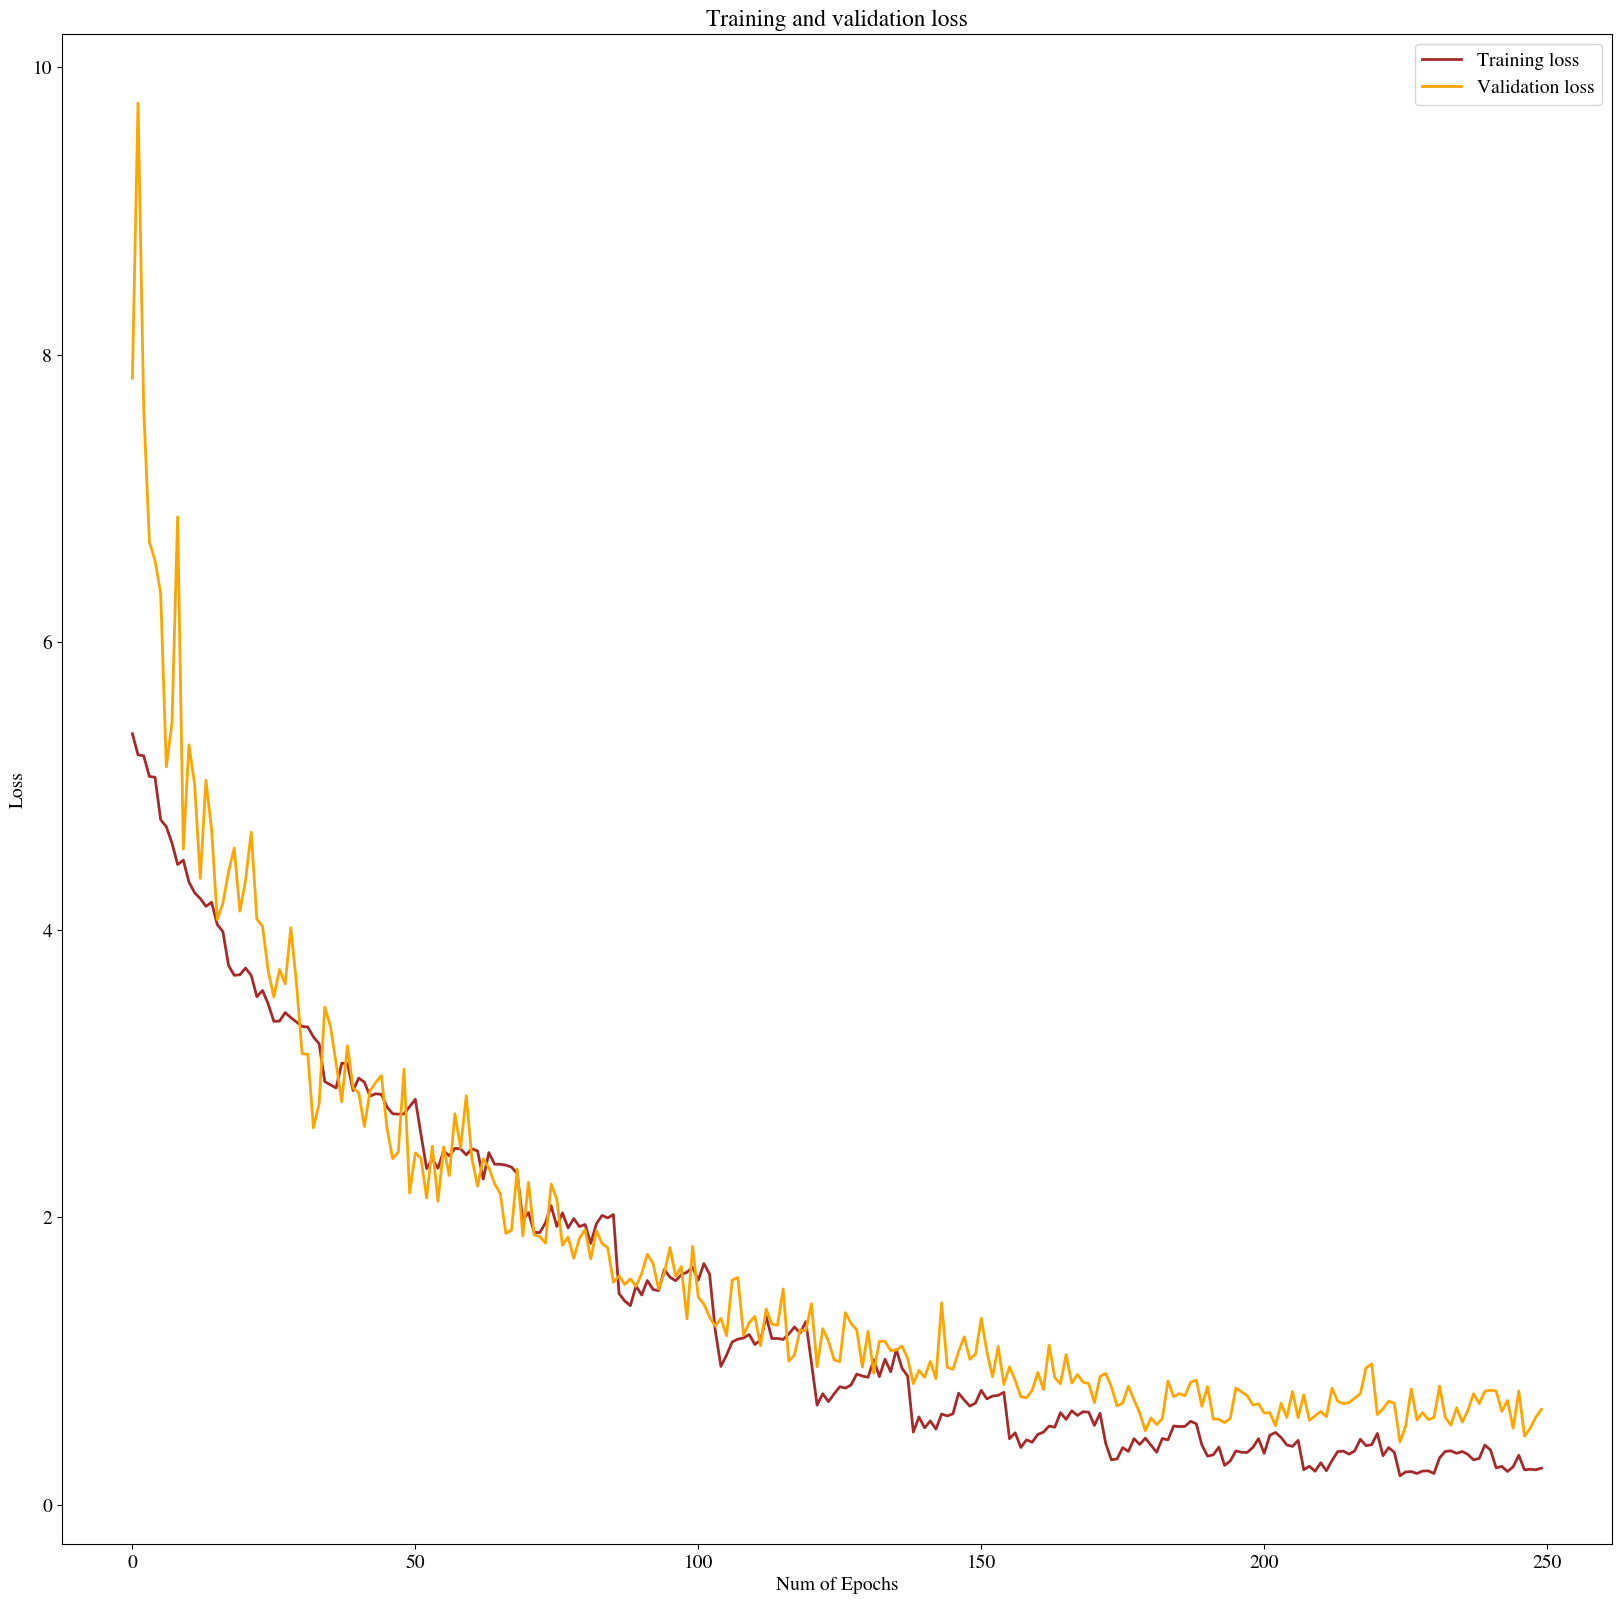


TEST accuracy: 0.76375
TEST loss: 0.781851960066706

Confusion Matrix
[[36  0  0 ...  0  0  0]
 [ 0 26  0 ...  0  0  0]
 [ 0  0 30 ...  0  0  0]
 ...
 [ 0  0  0 ... 21  0  0]
 [ 0  0  0 ...  0 20  0]
 [ 0  0  0 ...  0  0 24]]

Classification Report
                             precision    recall  f1-score   support

               Afghan_hound       0.92      0.97      0.95        37
        African_hunting_dog       1.00      1.00      1.00        26
                   Airedale       0.61      0.97      0.75        31
                Appenzeller       0.73      0.67      0.70        24
         Australian_terrier       0.96      0.90      0.93        30
         Bedlington_terrier       0.85      0.82      0.84        28
       Bernese_mountain_dog       0.93      0.74      0.82        34
           Blenheim_spaniel       0.96      0.79      0.87        29
              Border_collie       1.00      0.78      0.88        23
             Border_terrier       0.77      0.37      0.50 

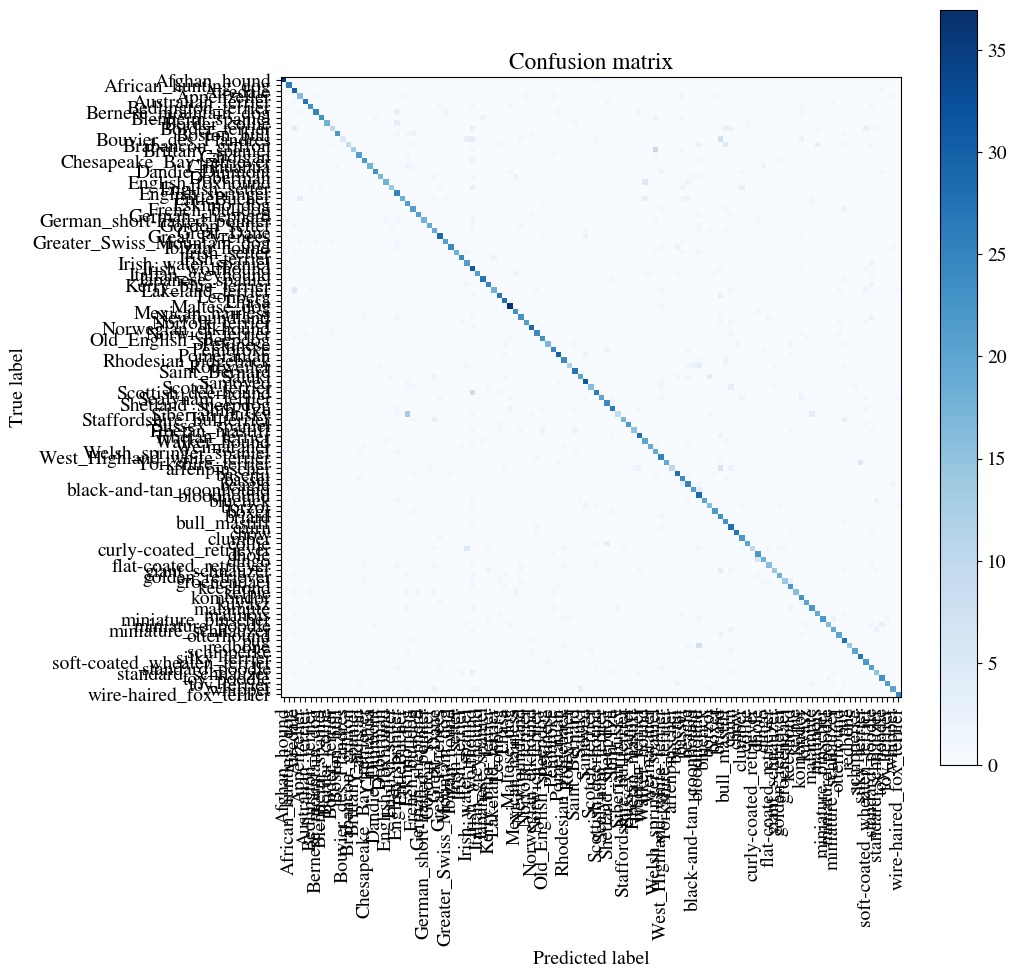

In [27]:
NUM_OF_DOGS = 115
EPOC = 250
run_Transfer_pipeline(NUM_OF_DOGS, EPOC)